In [11]:
import sys
sys.path.append('../')
import time
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from scipy.signal import convolve2d
from scipy.optimize import curve_fit
from scipy.optimize import brute
# import cv2
import torch
import json
import csv
from functions.all_knots_functions import *
from torch.utils.data import TensorDataset, DataLoader
from torch import nn
from sklearn.model_selection import train_test_split
from torch.optim import lr_scheduler
from torch.optim.lr_scheduler import ReduceLROnPlateau
import collections
import itertools
import torch
import torch.nn as nn
import torch.nn.functional as F
from tqdm import trange
import pickle
from sklearn.metrics import confusion_matrix
import seaborn as sns
from torchsummary import summary
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [12]:
desired_res = (24, 24, 24)

hyperparams = {
    'learning_rate': 1e-5,  # Control dropout rate
    'patience': 5,  # Number of epochs between learning rate decay
    'factor': 0.2,  # Multiplicative factor of learning rate decay
    'batch_size': 64
}
num_epochs = 100
print_every = 1
# in_channels, out_channels, kernel_size, stride, padding
stages = [
    [(1, 16, 3, 1, 1), (16, 16, 3, 1, 1), (16, 16, 3, 1, 1)],
    [(16, 32, 3, 1, 1), (32, 32, 3, 1, 1), (32, 32, 3, 1, 1)],
    [(32, 64, 5, 1, 1), (64,64, 5, 1, 1)]
]

# Define pooling configurations: (kernel_size, stride, padding)
# Set to 'None' for stages where no pooling is desired
# kernel_size, stride, padding
pooling_configs = [
    (2, 2, 1),  # Pooling after the first stage
    (2, 2, 1),  # Pooling after the second stage
    (2, 2, 1)      # No pooling after the third stage
]

In [13]:
knot_types = {
	'standard_14': 0,  # 1
	'standard_16': 1,  # 2
	'standard_18': 2,  # 3
	'30both': 3,  # 4
	'30oneZ': 4,  # 5
	'optimized': 5,  # 6
	'pm_03_z': 6,  # 7
	'30oneX': 7,  # 11
    '15oneZ': 8,
    'dennis': 9,
    'trefoil_standard_16': 10,
    'trefoil_optimized': 11

}
knots = [
	'standard_14', 'standard_16', 'standard_18', '30both', '30oneZ',
	'optimized', 'pm_03_z',
	'30oneX', '15oneZ', 'dennis',
    'trefoil_standard_16', 'trefoil_optimized'
]
folder = 'data_no_centers_135_13'


num_classes = len(knots)
X_list = []
Y_list = []
csv.field_size_limit(10000000)
for knot in knots:
    filename = f'../../../{folder}/data_{knot}.csv'
    # filename = f'../DATA/{folder}/data_{knot}.csv'
    with open(filename, 'r') as file:
        reader = csv.reader(file)
        for row in reader:
            # Deserialize the JSON string back to a list
            data_list = json.loads(row[0])
            # Convert the list back to a NumPy array if needed
            data_array = np.array(data_list)
            points_list = data_array[2:]
            Nx, Ny, Nz = data_array[1]
            if desired_res != (Nx, Ny, Nz):
                scale_x = desired_res[0] / Nx
                scale_y = desired_res[1] / Ny
                scale_z = desired_res[2] / Nz
                points_list = np.rint(points_list * np.array([scale_x, scale_y, scale_z])).astype(int)
            # Initialize a 3D array with zeros
            dots_3d = np.zeros(desired_res, dtype=int)
            # Set the specified coordinates to 1
            for x, y, z in points_list:
                try: dots_3d[x, y, z] = 1
                except IndexError: continue
            X_list.append(dots_3d)
            # X_list.append(data_array)
            Y_list.append(knot_types[knot])


In [14]:
X_np = np.array(X_list)
y_np = np.array(Y_list)
X_torch = torch.tensor(X_np).reshape(-1,1, *desired_res).float()
y_torch_list = torch.tensor(y_np)
y_torch = F.one_hot(y_torch_list.long(), num_classes=num_classes).float()
print(X_torch.shape, y_torch.shape)

torch.Size([12000, 1, 24, 24, 24]) torch.Size([12000, 12])


In [15]:
X_train, X_val_test, y_train, y_val_test = train_test_split(X_torch, y_torch, test_size=0.3, random_state=37)
X_val, X_test, y_val, y_test = train_test_split(X_val_test, y_val_test, test_size=0.5, random_state=37)
train_dataset = TensorDataset(X_train, y_train)
val_dataset = TensorDataset(X_val, y_val)
test_dataset = TensorDataset(X_test, y_test)

In [16]:
def conv_stage(layer_configs):
    layers = []
    for config in layer_configs:
        in_channels, out_channels, kernel_size, stride, padding = config
        layers.append(nn.Conv3d(in_channels, out_channels, kernel_size, stride, padding))
        layers.append(nn.BatchNorm3d(out_channels))
        layers.append(nn.ReLU(inplace=True))

    return nn.Sequential(*layers)

def create_pooling_layer(config):
    if config is None:
        return None
    kernel_size, stride, padding = config
    return nn.MaxPool3d(kernel_size=kernel_size, stride=stride, padding=padding)

class Classifier3D(nn.Module):
    def __init__(self, stages, pooling_configs, num_classes=11, desired=desired_res):
        super(Classifier3D, self).__init__()

        self.features = nn.Sequential()
        self.desired = desired_res

        for i, stage in enumerate(stages):
            # Add the convolutional stage
            self.features.add_module(f"stage_{i}", conv_stage(stage))

            # Add a custom MaxPooling layer after each stage based on the pooling configuration
            if i < len(pooling_configs):
                pool_layer = create_pooling_layer(pooling_configs[i])
                if pool_layer:
                    self.features.add_module(f"pool_{i}", pool_layer)


        # Calculate the size of the flattened features after the conv layers
        self._to_linear = None
        self._get_conv_output((1, *self.desired))

        # Fully connected layers
        self.fc1 = nn.Linear(self._to_linear, 256)
        # self.fc2 = nn.Linear(self._to_linear, 512)
        self.fc2 = nn.Linear(256, num_classes)

    def _get_conv_output(self, shape):
        batch_size = 1
        input = torch.autograd.Variable(torch.rand(batch_size, *shape))
        output_feat = self.features(input)
        self._to_linear = int(np.prod(output_feat.size()[1:]))

    def initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv3d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm3d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1) # Flatten the output
        x = F.relu(self.fc1(x))
        # x = F.relu(self.fc2(x))
        x = self.fc2(x)
        x = nn.Softmax(1)(x)
        return x


In [17]:


model = Classifier3D(stages, pooling_configs, num_classes=len(knots)).to(device)
model.initialize_weights()

In [18]:
# print(model._to_linear, 512 * 16 * 16)
dots_3d_toch_batch = train_dataset[1:2][0].to(device)
print(dots_3d_toch_batch.shape)
print(model(dots_3d_toch_batch))
summary(model, input_size=dots_3d_toch_batch.shape[1:])

torch.Size([1, 1, 24, 24, 24])
tensor([[0.0848, 0.0846, 0.0848, 0.0828, 0.0852, 0.0846, 0.0789, 0.0834, 0.0833,
         0.0826, 0.0844, 0.0805]], grad_fn=<SoftmaxBackward0>)
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv3d-1       [-1, 16, 24, 24, 24]             448
       BatchNorm3d-2       [-1, 16, 24, 24, 24]              32
              ReLU-3       [-1, 16, 24, 24, 24]               0
            Conv3d-4       [-1, 16, 24, 24, 24]           6,928
       BatchNorm3d-5       [-1, 16, 24, 24, 24]              32
              ReLU-6       [-1, 16, 24, 24, 24]               0
            Conv3d-7       [-1, 16, 24, 24, 24]           6,928
       BatchNorm3d-8       [-1, 16, 24, 24, 24]              32
              ReLU-9       [-1, 16, 24, 24, 24]               0
        MaxPool3d-10       [-1, 16, 13, 13, 13]               0
           Conv3d-11       [-1, 32, 13, 13, 13]         

In [19]:
def loop_train(model, train_loader, criterion, optimizer):
    model.train()  # Set the model to training mode
    total_loss = 0
    for i, (inputs, targets) in enumerate(train_loader, 1):  # Start enumeration from 1
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()  # Clear the gradients
        outputs = model(inputs)  # Forward pass
        loss = criterion(outputs, targets)  # Compute the loss
        loss.backward()  # Backward pass
        optimizer.step()  # Update the weights
        total_loss += loss.item()  # Accumulate the loss

    return total_loss / len(train_loader)  # Return the average loss


def loop_test(model, test_loader, criterion):
    model.eval()  # Set the model to evaluation mode
    total_loss = 0
    with torch.no_grad():  # No need to track the gradients
        for inputs, targets in test_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)  # Forward pass
            loss = criterion(outputs, targets)  # Compute the loss
            total_loss += loss.item()  # Accumulate the loss
    return total_loss / len(test_loader)  # Return the average loss


def correct_number_test(model, test_loader, criterion):
    model.eval()  # Set the model to evaluation mode
    total_correct = 0
    total = 0
    with torch.no_grad():  # No need to track the gradients
        for inputs, targets in test_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)  # Forward pass
            correct = criterion(outputs, targets)  # Compute correct
            total_correct += correct  # Accumulate correct
            total += len(outputs)  # Accumulate total
    return total_correct, total  # Return the average loss


def plot_losses(train_losses, test_losses, decimals=3):
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses,
             label=f'Train Loss {train_losses[-1]: .{decimals}f} (min: {min(train_losses): .{decimals}f})')
    plt.plot(test_losses, label=f'Test Loss {test_losses[-1]: .{decimals}f} (min: {min(test_losses): .{decimals}f})')
    plt.title('Training and Testing Losses Over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()


In [20]:

# criterion = nn.MSELoss().to(device)
criterion = nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=hyperparams['learning_rate'])
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=hyperparams['factor'], patience=hyperparams['patience'],
                              verbose=True)


train_losses = []
val_losses = []
train_loader = DataLoader(train_dataset, batch_size=hyperparams['batch_size'], shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=hyperparams['batch_size'])
test_loader = DataLoader(test_dataset, batch_size=hyperparams['batch_size'])
start_time = time.time()
for epoch in trange(num_epochs, desc="Progress"):
    epoch_start_time = time.time()
    train_losses.append(loop_train(model, train_loader, criterion, optimizer))
    val_losses.append(loop_test(model, val_loader, criterion))

    scheduler.step(val_losses[-1])

    if (epoch + 1) % print_every == 0:
        epoch_time = time.time() - epoch_start_time
        print(f'Epoch {epoch} completed in {epoch_time:.2f} seconds')
        print(f'Epoch {epoch}: Train Loss: {train_losses[-1]:.4f}, Val Loss: {val_losses[-1]:.4f}')


total_training_time = time.time() - start_time
print(f'Total training time: {total_training_time:.2f} seconds')


Progress:   1%|          | 1/100 [02:03<3:23:16, 123.19s/it]

Epoch 0 completed in 123.19 seconds
Epoch 0: Train Loss: 2.4807, Val Loss: 2.4693


Progress:   2%|▏         | 2/100 [04:06<3:20:57, 123.03s/it]

Epoch 1 completed in 122.92 seconds
Epoch 1: Train Loss: 2.4397, Val Loss: 2.4146


Progress:   3%|▎         | 3/100 [06:09<3:18:50, 123.00s/it]

Epoch 2 completed in 122.95 seconds
Epoch 2: Train Loss: 2.3960, Val Loss: 2.3753


Progress:   4%|▍         | 4/100 [08:13<3:17:55, 123.71s/it]

Epoch 3 completed in 124.80 seconds
Epoch 3: Train Loss: 2.3412, Val Loss: 2.3193


Progress:   5%|▌         | 5/100 [10:18<3:16:22, 124.03s/it]

Epoch 4 completed in 124.59 seconds
Epoch 4: Train Loss: 2.2991, Val Loss: 2.2911


Progress:   6%|▌         | 6/100 [12:35<3:21:26, 128.58s/it]

Epoch 5 completed in 137.43 seconds
Epoch 5: Train Loss: 2.2761, Val Loss: 2.2725


Progress:   7%|▋         | 7/100 [15:04<3:29:35, 135.22s/it]

Epoch 6 completed in 148.89 seconds
Epoch 6: Train Loss: 2.2624, Val Loss: 2.2615


Progress:   8%|▊         | 8/100 [17:31<3:33:06, 138.98s/it]

Epoch 7 completed in 147.02 seconds
Epoch 7: Train Loss: 2.2500, Val Loss: 2.2499


Progress:   9%|▉         | 9/100 [19:57<3:33:45, 140.94s/it]

Epoch 8 completed in 145.24 seconds
Epoch 8: Train Loss: 2.2404, Val Loss: 2.2391


Progress:  10%|█         | 10/100 [22:22<3:33:43, 142.48s/it]

Epoch 9 completed in 145.93 seconds
Epoch 9: Train Loss: 2.2284, Val Loss: 2.2283


Progress:  11%|█         | 11/100 [24:48<3:32:38, 143.35s/it]

Epoch 10 completed in 145.33 seconds
Epoch 10: Train Loss: 2.2191, Val Loss: 2.2190


Progress:  12%|█▏        | 12/100 [27:13<3:31:00, 143.87s/it]

Epoch 11 completed in 145.07 seconds
Epoch 11: Train Loss: 2.2089, Val Loss: 2.2107


Progress:  13%|█▎        | 13/100 [29:38<3:29:06, 144.21s/it]

Epoch 12 completed in 144.98 seconds
Epoch 12: Train Loss: 2.2015, Val Loss: 2.2027


Progress:  14%|█▍        | 14/100 [32:02<3:26:45, 144.26s/it]

Epoch 13 completed in 144.36 seconds
Epoch 13: Train Loss: 2.1870, Val Loss: 2.1849


Progress:  15%|█▌        | 15/100 [34:26<3:24:21, 144.25s/it]

Epoch 14 completed in 144.25 seconds
Epoch 14: Train Loss: 2.1681, Val Loss: 2.1686


Progress:  16%|█▌        | 16/100 [36:51<3:21:55, 144.23s/it]

Epoch 15 completed in 144.19 seconds
Epoch 15: Train Loss: 2.1513, Val Loss: 2.1550


Progress:  17%|█▋        | 17/100 [39:15<3:19:37, 144.30s/it]

Epoch 16 completed in 144.46 seconds
Epoch 16: Train Loss: 2.1391, Val Loss: 2.1465


Progress:  18%|█▊        | 18/100 [41:34<3:14:56, 142.64s/it]

Epoch 17 completed in 138.75 seconds
Epoch 17: Train Loss: 2.1292, Val Loss: 2.1385


Progress:  19%|█▉        | 19/100 [43:34<3:03:17, 135.77s/it]

Epoch 18 completed in 119.76 seconds
Epoch 18: Train Loss: 2.1188, Val Loss: 2.1279


Progress:  20%|██        | 20/100 [45:33<2:54:28, 130.85s/it]

Epoch 19 completed in 119.40 seconds
Epoch 19: Train Loss: 2.1088, Val Loss: 2.1249


Progress:  21%|██        | 21/100 [47:32<2:47:44, 127.40s/it]

Epoch 20 completed in 119.33 seconds
Epoch 20: Train Loss: 2.1003, Val Loss: 2.1128


Progress:  22%|██▏       | 22/100 [49:32<2:42:28, 124.98s/it]

Epoch 21 completed in 119.35 seconds
Epoch 21: Train Loss: 2.0919, Val Loss: 2.1079


Progress:  23%|██▎       | 23/100 [51:32<2:38:24, 123.44s/it]

Epoch 22 completed in 119.83 seconds
Epoch 22: Train Loss: 2.0828, Val Loss: 2.1012


Progress:  24%|██▍       | 24/100 [53:31<2:34:52, 122.27s/it]

Epoch 23 completed in 119.54 seconds
Epoch 23: Train Loss: 2.0713, Val Loss: 2.0946


Progress:  25%|██▌       | 25/100 [55:31<2:31:56, 121.56s/it]

Epoch 24 completed in 119.90 seconds
Epoch 24: Train Loss: 2.0634, Val Loss: 2.0845


Progress:  26%|██▌       | 26/100 [57:31<2:29:12, 120.99s/it]

Epoch 25 completed in 119.65 seconds
Epoch 25: Train Loss: 2.0527, Val Loss: 2.0776


Progress:  27%|██▋       | 27/100 [59:30<2:26:42, 120.59s/it]

Epoch 26 completed in 119.65 seconds
Epoch 26: Train Loss: 2.0437, Val Loss: 2.0698


Progress:  28%|██▊       | 28/100 [1:01:30<2:24:22, 120.32s/it]

Epoch 27 completed in 119.68 seconds
Epoch 27: Train Loss: 2.0340, Val Loss: 2.0606


Progress:  29%|██▉       | 29/100 [1:03:30<2:22:14, 120.21s/it]

Epoch 28 completed in 119.96 seconds
Epoch 28: Train Loss: 2.0254, Val Loss: 2.0545


Progress:  30%|███       | 30/100 [1:05:30<2:20:08, 120.13s/it]

Epoch 29 completed in 119.93 seconds
Epoch 29: Train Loss: 2.0170, Val Loss: 2.0532


Progress:  31%|███       | 31/100 [1:07:30<2:18:06, 120.09s/it]

Epoch 30 completed in 120.01 seconds
Epoch 30: Train Loss: 2.0090, Val Loss: 2.0423


Progress:  32%|███▏      | 32/100 [1:09:30<2:16:02, 120.03s/it]

Epoch 31 completed in 119.90 seconds
Epoch 31: Train Loss: 2.0005, Val Loss: 2.0422


Progress:  33%|███▎      | 33/100 [1:11:29<2:13:52, 119.88s/it]

Epoch 32 completed in 119.53 seconds
Epoch 32: Train Loss: 1.9944, Val Loss: 2.0367


Progress:  34%|███▍      | 34/100 [1:13:30<2:12:00, 120.01s/it]

Epoch 33 completed in 120.32 seconds
Epoch 33: Train Loss: 1.9874, Val Loss: 2.0391


Progress:  35%|███▌      | 35/100 [1:15:30<2:10:03, 120.05s/it]

Epoch 34 completed in 120.13 seconds
Epoch 34: Train Loss: 1.9804, Val Loss: 2.0397


Progress:  36%|███▌      | 36/100 [1:17:31<2:08:24, 120.39s/it]

Epoch 35 completed in 121.18 seconds
Epoch 35: Train Loss: 1.9748, Val Loss: 2.0232


Progress:  37%|███▋      | 37/100 [1:19:32<2:06:38, 120.61s/it]

Epoch 36 completed in 121.13 seconds
Epoch 36: Train Loss: 1.9698, Val Loss: 2.0299


Progress:  38%|███▊      | 38/100 [1:21:34<2:05:05, 121.05s/it]

Epoch 37 completed in 122.07 seconds
Epoch 37: Train Loss: 1.9626, Val Loss: 2.0191


Progress:  39%|███▉      | 39/100 [1:23:37<2:03:28, 121.45s/it]

Epoch 38 completed in 122.40 seconds
Epoch 38: Train Loss: 1.9572, Val Loss: 2.0190


Progress:  40%|████      | 40/100 [1:25:39<2:01:44, 121.74s/it]

Epoch 39 completed in 122.41 seconds
Epoch 39: Train Loss: 1.9535, Val Loss: 2.0223


Progress:  41%|████      | 41/100 [1:27:41<1:59:46, 121.81s/it]

Epoch 40 completed in 121.97 seconds
Epoch 40: Train Loss: 1.9463, Val Loss: 2.0146


Progress:  42%|████▏     | 42/100 [1:29:43<1:57:42, 121.77s/it]

Epoch 41 completed in 121.69 seconds
Epoch 41: Train Loss: 1.9411, Val Loss: 2.0123


Progress:  43%|████▎     | 43/100 [1:31:49<1:57:08, 123.30s/it]

Epoch 42 completed in 126.85 seconds
Epoch 42: Train Loss: 1.9377, Val Loss: 2.0154


Progress:  44%|████▍     | 44/100 [1:33:55<1:55:39, 123.93s/it]

Epoch 43 completed in 125.39 seconds
Epoch 43: Train Loss: 1.9329, Val Loss: 2.0104


Progress:  45%|████▌     | 45/100 [1:35:56<1:52:56, 123.21s/it]

Epoch 44 completed in 121.53 seconds
Epoch 44: Train Loss: 1.9286, Val Loss: 2.0113


Progress:  46%|████▌     | 46/100 [1:37:58<1:50:33, 122.84s/it]

Epoch 45 completed in 121.99 seconds
Epoch 45: Train Loss: 1.9227, Val Loss: 2.0066


Progress:  47%|████▋     | 47/100 [1:40:01<1:48:23, 122.70s/it]

Epoch 46 completed in 122.38 seconds
Epoch 46: Train Loss: 1.9179, Val Loss: 2.0083


Progress:  48%|████▊     | 48/100 [1:42:03<1:46:11, 122.52s/it]

Epoch 47 completed in 122.10 seconds
Epoch 47: Train Loss: 1.9130, Val Loss: 2.0233


Progress:  49%|████▉     | 49/100 [1:44:06<1:44:12, 122.60s/it]

Epoch 48 completed in 122.76 seconds
Epoch 48: Train Loss: 1.9121, Val Loss: 2.0062


Progress:  50%|█████     | 50/100 [1:46:08<1:42:11, 122.62s/it]

Epoch 49 completed in 122.68 seconds
Epoch 49: Train Loss: 1.9057, Val Loss: 2.0044


Progress:  51%|█████     | 51/100 [1:48:11<1:40:08, 122.62s/it]

Epoch 50 completed in 122.63 seconds
Epoch 50: Train Loss: 1.9019, Val Loss: 2.0025


Progress:  52%|█████▏    | 52/100 [1:50:13<1:38:02, 122.55s/it]

Epoch 51 completed in 122.39 seconds
Epoch 51: Train Loss: 1.8955, Val Loss: 2.0001


Progress:  53%|█████▎    | 53/100 [1:52:16<1:36:01, 122.58s/it]

Epoch 52 completed in 122.65 seconds
Epoch 52: Train Loss: 1.8935, Val Loss: 1.9983


Progress:  54%|█████▍    | 54/100 [1:54:19<1:34:06, 122.74s/it]

Epoch 53 completed in 123.12 seconds
Epoch 53: Train Loss: 1.8887, Val Loss: 2.0079


Progress:  55%|█████▌    | 55/100 [1:56:22<1:32:06, 122.81s/it]

Epoch 54 completed in 122.98 seconds
Epoch 54: Train Loss: 1.8857, Val Loss: 2.0014


Progress:  56%|█████▌    | 56/100 [1:58:26<1:30:16, 123.11s/it]

Epoch 55 completed in 123.79 seconds
Epoch 55: Train Loss: 1.8815, Val Loss: 2.0029


Progress:  57%|█████▋    | 57/100 [2:00:29<1:28:17, 123.20s/it]

Epoch 56 completed in 123.43 seconds
Epoch 56: Train Loss: 1.8795, Val Loss: 1.9975


Progress:  58%|█████▊    | 58/100 [2:02:33<1:26:20, 123.36s/it]

Epoch 57 completed in 123.71 seconds
Epoch 57: Train Loss: 1.8747, Val Loss: 1.9988


Progress:  59%|█████▉    | 59/100 [2:04:37<1:24:22, 123.49s/it]

Epoch 58 completed in 123.79 seconds
Epoch 58: Train Loss: 1.8694, Val Loss: 2.0024


Progress:  60%|██████    | 60/100 [2:06:42<1:22:36, 123.90s/it]

Epoch 59 completed in 124.87 seconds
Epoch 59: Train Loss: 1.8653, Val Loss: 2.0041


Progress:  61%|██████    | 61/100 [2:08:45<1:20:26, 123.76s/it]

Epoch 60 completed in 123.44 seconds
Epoch 60: Train Loss: 1.8627, Val Loss: 1.9938


Progress:  62%|██████▏   | 62/100 [2:10:48<1:18:18, 123.64s/it]

Epoch 61 completed in 123.37 seconds
Epoch 61: Train Loss: 1.8604, Val Loss: 1.9995


Progress:  63%|██████▎   | 63/100 [2:12:52<1:16:09, 123.50s/it]

Epoch 62 completed in 123.15 seconds
Epoch 62: Train Loss: 1.8540, Val Loss: 1.9979


Progress:  64%|██████▍   | 64/100 [2:14:55<1:14:03, 123.44s/it]

Epoch 63 completed in 123.29 seconds
Epoch 63: Train Loss: 1.8520, Val Loss: 2.0008


Progress:  65%|██████▌   | 65/100 [2:16:58<1:11:55, 123.31s/it]

Epoch 64 completed in 123.02 seconds
Epoch 64: Train Loss: 1.8471, Val Loss: 1.9954


Progress:  66%|██████▌   | 66/100 [2:19:01<1:09:52, 123.31s/it]

Epoch 65 completed in 123.31 seconds
Epoch 65: Train Loss: 1.8430, Val Loss: 2.0188


Progress:  67%|██████▋   | 67/100 [2:21:04<1:07:48, 123.28s/it]

Epoch 00067: reducing learning rate of group 0 to 2.0000e-06.
Epoch 66 completed in 123.21 seconds
Epoch 66: Train Loss: 1.8395, Val Loss: 1.9964


Progress:  68%|██████▊   | 68/100 [2:23:08<1:05:42, 123.21s/it]

Epoch 67 completed in 123.03 seconds
Epoch 67: Train Loss: 1.8336, Val Loss: 1.9932


Progress:  69%|██████▉   | 69/100 [2:25:11<1:03:39, 123.21s/it]

Epoch 68 completed in 123.21 seconds
Epoch 68: Train Loss: 1.8298, Val Loss: 1.9939


Progress:  70%|███████   | 70/100 [2:27:16<1:01:53, 123.77s/it]

Epoch 69 completed in 125.08 seconds
Epoch 69: Train Loss: 1.8302, Val Loss: 1.9944


Progress:  71%|███████   | 71/100 [2:29:19<59:46, 123.67s/it]  

Epoch 70 completed in 123.42 seconds
Epoch 70: Train Loss: 1.8292, Val Loss: 1.9960


Progress:  72%|███████▏  | 72/100 [2:31:23<57:46, 123.81s/it]

Epoch 71 completed in 124.13 seconds
Epoch 71: Train Loss: 1.8281, Val Loss: 1.9958


Progress:  73%|███████▎  | 73/100 [2:33:27<55:41, 123.75s/it]

Epoch 72 completed in 123.61 seconds
Epoch 72: Train Loss: 1.8267, Val Loss: 1.9946


Progress:  74%|███████▍  | 74/100 [2:35:30<53:29, 123.46s/it]

Epoch 00074: reducing learning rate of group 0 to 4.0000e-07.
Epoch 73 completed in 122.79 seconds
Epoch 73: Train Loss: 1.8265, Val Loss: 1.9953


Progress:  75%|███████▌  | 75/100 [2:37:34<51:32, 123.72s/it]

Epoch 74 completed in 124.32 seconds
Epoch 74: Train Loss: 1.8245, Val Loss: 1.9951


Progress:  76%|███████▌  | 76/100 [2:39:37<49:24, 123.51s/it]

Epoch 75 completed in 123.00 seconds
Epoch 75: Train Loss: 1.8245, Val Loss: 1.9951


Progress:  77%|███████▋  | 77/100 [2:41:40<47:15, 123.30s/it]

Epoch 76 completed in 122.83 seconds
Epoch 76: Train Loss: 1.8244, Val Loss: 1.9943


Progress:  78%|███████▊  | 78/100 [2:43:42<45:02, 122.85s/it]

Epoch 77 completed in 121.79 seconds
Epoch 77: Train Loss: 1.8241, Val Loss: 1.9952


Progress:  79%|███████▉  | 79/100 [2:45:43<42:53, 122.53s/it]

Epoch 78 completed in 121.77 seconds
Epoch 78: Train Loss: 1.8245, Val Loss: 1.9954


Progress:  80%|████████  | 80/100 [2:47:46<40:50, 122.54s/it]

Epoch 00080: reducing learning rate of group 0 to 8.0000e-08.
Epoch 79 completed in 122.58 seconds
Epoch 79: Train Loss: 1.8243, Val Loss: 1.9944


Progress:  81%|████████  | 81/100 [2:49:47<38:41, 122.17s/it]

Epoch 80 completed in 121.32 seconds
Epoch 80: Train Loss: 1.8225, Val Loss: 1.9969


Progress:  82%|████████▏ | 82/100 [2:51:51<36:46, 122.57s/it]

Epoch 81 completed in 123.49 seconds
Epoch 81: Train Loss: 1.8233, Val Loss: 1.9969


Progress:  83%|████████▎ | 83/100 [2:53:55<34:51, 123.02s/it]

Epoch 82 completed in 124.06 seconds
Epoch 82: Train Loss: 1.8230, Val Loss: 1.9972


Progress:  84%|████████▍ | 84/100 [2:55:58<32:47, 122.97s/it]

Epoch 83 completed in 122.87 seconds
Epoch 83: Train Loss: 1.8246, Val Loss: 1.9953


Progress:  85%|████████▌ | 85/100 [2:58:01<30:45, 123.02s/it]

Epoch 84 completed in 123.13 seconds
Epoch 84: Train Loss: 1.8234, Val Loss: 1.9945


Progress:  86%|████████▌ | 86/100 [3:00:03<28:36, 122.63s/it]

Epoch 00086: reducing learning rate of group 0 to 1.6000e-08.
Epoch 85 completed in 121.71 seconds
Epoch 85: Train Loss: 1.8235, Val Loss: 1.9955


Progress:  87%|████████▋ | 87/100 [3:02:05<26:33, 122.55s/it]

Epoch 86 completed in 122.36 seconds
Epoch 86: Train Loss: 1.8223, Val Loss: 1.9955


Progress:  88%|████████▊ | 88/100 [3:04:09<24:34, 122.86s/it]

Epoch 87 completed in 123.58 seconds
Epoch 87: Train Loss: 1.8230, Val Loss: 1.9955


Progress:  89%|████████▉ | 89/100 [3:06:12<22:34, 123.10s/it]

Epoch 88 completed in 123.66 seconds
Epoch 88: Train Loss: 1.8219, Val Loss: 1.9961


Progress:  90%|█████████ | 90/100 [3:08:15<20:29, 122.97s/it]

Epoch 89 completed in 122.68 seconds
Epoch 89: Train Loss: 1.8230, Val Loss: 1.9957


Progress:  91%|█████████ | 91/100 [3:10:15<18:18, 122.10s/it]

Epoch 90 completed in 120.06 seconds
Epoch 90: Train Loss: 1.8230, Val Loss: 1.9955


Progress:  92%|█████████▏| 92/100 [3:12:15<16:11, 121.44s/it]

Epoch 00092: reducing learning rate of group 0 to 3.2000e-09.
Epoch 91 completed in 119.91 seconds
Epoch 91: Train Loss: 1.8224, Val Loss: 1.9951


Progress:  93%|█████████▎| 93/100 [3:14:14<14:05, 120.83s/it]

Epoch 92 completed in 119.42 seconds
Epoch 92: Train Loss: 1.8226, Val Loss: 1.9954


Progress:  94%|█████████▍| 94/100 [3:16:14<12:02, 120.45s/it]

Epoch 93 completed in 119.56 seconds
Epoch 93: Train Loss: 1.8230, Val Loss: 1.9967


Progress:  95%|█████████▌| 95/100 [3:18:13<10:00, 120.17s/it]

Epoch 94 completed in 119.49 seconds
Epoch 94: Train Loss: 1.8242, Val Loss: 1.9942


Progress:  96%|█████████▌| 96/100 [3:20:13<07:59, 119.90s/it]

Epoch 95 completed in 119.29 seconds
Epoch 95: Train Loss: 1.8233, Val Loss: 1.9956


Progress:  97%|█████████▋| 97/100 [3:22:13<05:59, 119.89s/it]

Epoch 96 completed in 119.85 seconds
Epoch 96: Train Loss: 1.8234, Val Loss: 1.9946


Progress:  98%|█████████▊| 98/100 [3:24:12<03:59, 119.80s/it]

Epoch 97 completed in 119.61 seconds
Epoch 97: Train Loss: 1.8228, Val Loss: 1.9950


Progress:  99%|█████████▉| 99/100 [3:26:12<01:59, 119.74s/it]

Epoch 98 completed in 119.58 seconds
Epoch 98: Train Loss: 1.8220, Val Loss: 1.9945


Progress: 100%|██████████| 100/100 [3:28:11<00:00, 124.92s/it]

Epoch 99 completed in 119.46 seconds
Epoch 99: Train Loss: 1.8219, Val Loss: 1.9950
Total training time: 12491.68 seconds


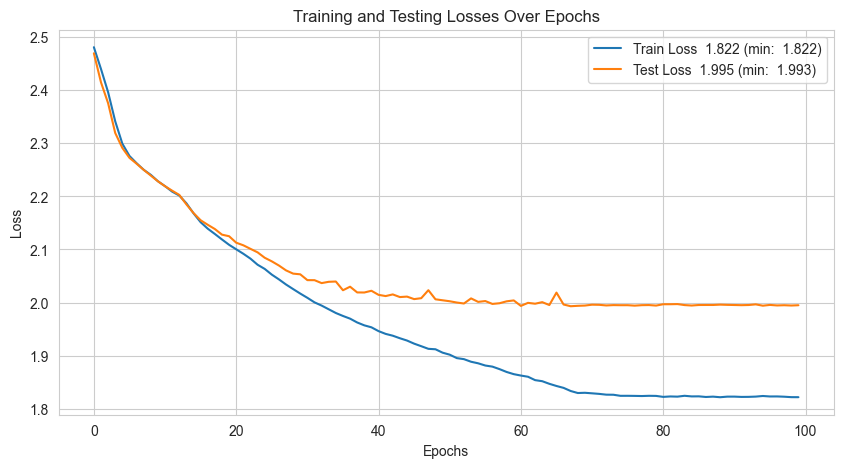

In [21]:
plot_losses(train_losses, val_losses, decimals=3)

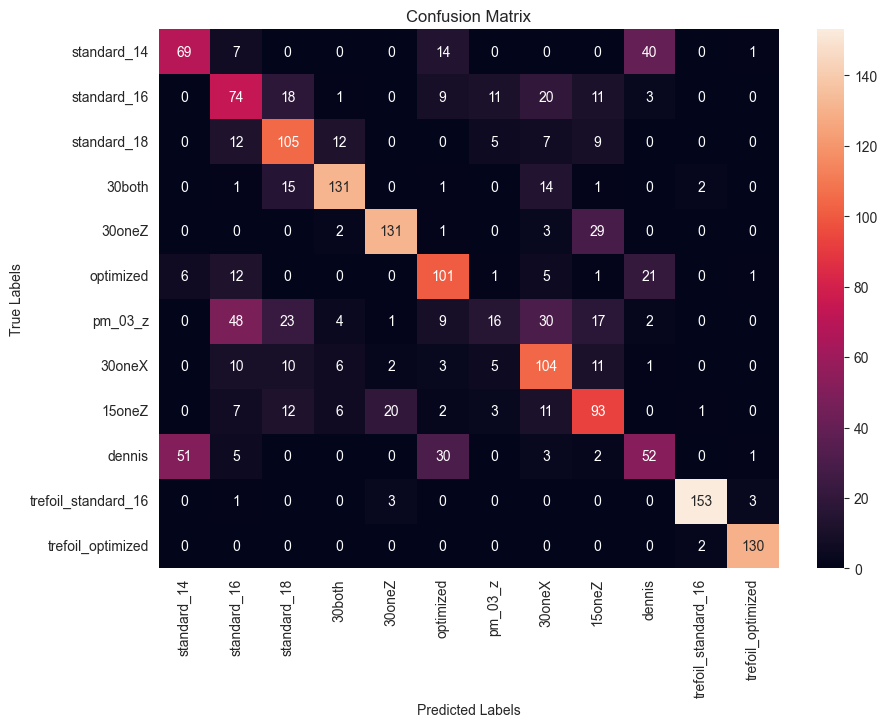

In [22]:
# predictions = model(X_torch.to(device))
# predictions
_, predicted_labels = torch.max(model(X_test.to(device)), 1)
_, true_class_labels = torch.max(y_test, 1)
predicted_labels_np = predicted_labels.cpu().numpy()
true_labels_np = true_class_labels.cpu().numpy()
cm = confusion_matrix(true_labels_np, predicted_labels_np)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt="d", xticklabels=knots, yticklabels=knots)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [23]:
Accuracy = (np.sum(predicted_labels_np == true_labels_np)) / len(predicted_labels_np)
print(Accuracy)

0.6438888888888888


In [24]:
def criterion_correct(predictions, labels):
    _, predicted_labels = torch.max(predictions, 1)
    _, true_class_labels = torch.max(labels, 1)
    # print(predicted_labels)
    # print(y_torch)
    correct_predictions = torch.sum(predicted_labels == true_class_labels).item()
    return correct_predictions


correct_predictions, total = correct_number_test(model, test_loader, criterion_correct)
print(f"Number of correct predictions (test): {correct_predictions}/{total}")

correct_predictions, total = correct_number_test(model, val_loader, criterion_correct)
print(f"Number of correct predictions (val): {correct_predictions}/{total}")

Number of correct predictions (test): 1159/1800
Number of correct predictions (val): 1150/1800


Creating the least of the weights in 2D as a basis

In [25]:
def build_weights(weights, ls, ps, l1, l2, p1, p2):
    weights_ar = np.zeros(((l2 - l1 + 1), (p2 - p1 + 1)), dtype=complex)
    for l, p, weight in zip(ls, ps, weights):
        weights_ar[l - l1, p - p1] = weight
    return weights_ar

# getting the dimensions
filename = f'..\\{folder}\\data_{knots[0]}_spectr.csv'
with open(filename, 'r') as file:
    reader = csv.reader(file)
    row = next(iter(reader))
    data_list = json.loads(row[0])
    # Convert the list back to a NumPy array if needed
    # print(data_list)
    # data_array = np.array(data_list)
    data_array = data_list

    l1, l2 = data_array[0], data_array[1]
    p1, p2 = data_array[2], data_array[3]
print(l1, l2, p1, p2)

values_basis = []
for knot in knots:
# for knot in ['6foil']:
    print(knot)
    with open(f'..\\{folder}\\{knot}.pkl', 'rb') as file:

        file = pickle.load(file)
        ls = file['l']
        ps = file['p']
        weights = file['weight']
        values = build_weights(weights, ls, ps, l1, l2, p1, p2)
        values = values / np.sqrt(np.sum(np.abs(values) ** 2))
        values_basis.append(values)
        # plt.imshow(np.abs(values).T[::-1])
        # plt.colorbar()
        # plt.show()

print(len(values_basis), values_basis[0].shape)

FileNotFoundError: [Errno 2] No such file or directory: '..\\data_no_centers_135_13\\data_standard_14_spectr.csv'

In [ ]:
# Function to calculate MSE
def calculate_mse(array1, array2):
    return ((np.abs(array1) - np.abs(array2)) ** 2).mean()

closest_basis_knots = []
true_labels = []
for knot in knots:
    closest_basis_knot = []
    true_label = []
# for knot in ['6foil']:
    filename = f'..\\{folder}\\data_{knot}_spectr.csv'

    with open(filename, 'r') as file:
        reader = csv.reader(file)
        for row in reader:
            true_label.append(knot_types[knot])
            data_array = json.loads(row[0])

            # indx = data_array[4]
            # field = np.load(f'..\\{folder}\\fields\\data_{knot}_{indx}.npy')
            # plt.imshow(np.abs(field ))
            # plt.show()

            moments = np.array([x[0] + 1j * x[1] for x in data_array[5:]]).reshape((l2 - l1 + 1), (p2 - p1 + 1))
            moments = moments / np.sqrt(np.sum(np.abs(moments) ** 2))
            mse_scores = [calculate_mse(moments, values) for values in values_basis]
            closest_basis_knot.append(np.argmin(mse_scores))
            # plt.imshow(np.abs(moments))
            # plt.colorbar()
            # plt.show()
    true_labels.append(true_label)
    closest_basis_knots.append(closest_basis_knot)

# print(len(closest_basis_knots), len(closest_basis_knots[0]), print(closest_basis_knots[0]))
# print(true_labels)
# print(closest_basis_knots)


In [ ]:
predicted_labels_spec_np = np.array(closest_basis_knots).reshape(-1)
true_labels_spec_np = np.array(true_labels).reshape(-1)
# print(true_labels_spec_np)
cm = confusion_matrix(true_labels_spec_np, predicted_labels_spec_np)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt="d", xticklabels=knots, yticklabels=knots)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()


In [ ]:
# def build_weights(weights, ls, ps, l1, l2, p1, p2):
#     weights_ar = np.zeros(((l2 - l1 + 1), (p2 - p1 + 1)), dtype=complex)
#     for l, p, weight in zip(ls, ps, weights):
#         weights_ar[l - l1, p - p1] = weight
#     return weights_ar
#
# # getting the dimensions
# filename = f'..\\{folder}\\data_{knots[0]}_spectr.csv'
# with open(filename, 'r') as file:
#     reader = csv.reader(file)
#     row = next(iter(reader))
#     data_list = json.loads(row[0])
#     # Convert the list back to a NumPy array if needed
#     # print(data_list)
#     # data_array = np.array(data_list)
#     data_array = data_list
#
#     l1, l2 = data_array[0], data_array[1]
#     p1, p2 = data_array[2], data_array[3]
# print(l1, l2, p1, p2)

knots_basis = []
knots_basis_dots = []
for knot in knots:
# for knot in ['6foil']:
    filename = f'..\\data_basis\\data_{knot}.csv'

    with open(filename, 'r') as file:
        reader = csv.reader(file)
        for row in reader:
            # Deserialize the JSON string back to a list
            data_list = json.loads(row[0])
            # Convert the list back to a NumPy array if needed
            data_array = np.array(data_list)
            points_list = data_array[2:]

            Nx, Ny, Nz = data_array[1]
            if desired_res != (Nx, Ny, Nz):
                scale_x = desired_res[0] / Nx
                scale_y = desired_res[1] / Ny
                scale_z = desired_res[2] / Nz
                points_list = np.rint(points_list * np.array([scale_x, scale_y, scale_z])).astype(int)
            knots_basis_dots.append(points_list)
            # Initialize a 3D array with zeros
            dots_3d = np.zeros(desired_res, dtype=int)
            # Set the specified coordinates to 1
            for x, y, z in points_list:
                try: dots_3d[x, y, z] = 1
                except IndexError: continue
            knots_basis.append(dots_3d)

print(len(knots_basis), knots_basis[0].shape)
print(len(knots_basis_dots), knots_basis_dots[0].shape,knots_basis_dots[0][0])
print(knots_basis_dots[0].shape, knots_basis_dots[3].shape)

In [ ]:
# Function to calculate MSE
def calculate_mse_knot(array1, array2):
    return ((array1 - array2) ** 2).mean()

def calculate_mse_knot_dots(array1, dots):
    # loss = -np.sum([np.array(array1)[np.array(dot)] for dot in dots])
    loss = -np.sum([array1[tuple(dot)] for dot in dots])

    return loss

closest_knots = []
closest_knots_dots = []
true_knots = []
j = -1
for i, x in enumerate(X_torch):
    j += 1
    true_knots.append(torch.argmax(y_torch[i]).item())

    mse_scores = [calculate_mse_knot(x[0], knot_) for knot_ in knots_basis]
    closest_knots.append(np.argmin(mse_scores))

    mse_scores_dots = [calculate_mse_knot_dots(x[0], dots_) for dots_ in knots_basis_dots]
    # print(mse_scores_dots)
    # min_indices = np.where(mse_scores_dots == np.min(mse_scores_dots))[0]
    # if len(min_indices) > 1:
    #     result = 0
    # else:
    #     result = min_indices[0]
    closest_knots_dots.append(np.argmin(mse_scores_dots))
    # plt.imshow(knots_basis[j][:, :, 8])
    # plt.colorbar()
    # plt.show()
    # plt.imshow(x[0][:, :, 8])
    # plt.colorbar()
    # plt.show()
    # break


# print(len(closest_basis_knots), len(closest_basis_knots[0]), print(closest_basis_knots[0]))
# print(true_labels)
# print(closest_basis_knots)


In [ ]:

predicted_labels_spec_np = np.array(closest_knots).reshape(-1)
true_labels_spec_np = np.array(true_knots).reshape(-1)
# print(true_labels_spec_np)
cm = confusion_matrix(true_labels_spec_np, predicted_labels_spec_np)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt="d", xticklabels=knots, yticklabels=knots)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [ ]:

predicted_labels_spec_np = np.array(closest_knots_dots).reshape(-1)
true_labels_spec_np = np.array(true_knots).reshape(-1)
# print(true_labels_spec_np)
cm = confusion_matrix(true_labels_spec_np, predicted_labels_spec_np)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt="d", xticklabels=knots, yticklabels=knots)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [ ]:


X_list_sp = []
Y_list_sp = []
for knot in knots:
# for knot in ['6foil']:
    filename = f'..\\{folder}\\data_{knot}_spectr.csv'
    with open(f'..\\{folder}\\{knot}.pkl', 'rb') as file:
        file = pickle.load(file)
        ls = file['l']
        ps = file['p']
        weights = file['weight']
        for row in reader:
                # Deserialize the JSON string back to a list
                data_list = json.loads(row[0])
                # Convert the list back to a NumPy array if needed
                # print(data_list)
                # data_array = np.array(data_list)
                data_array = data_list

                l1, l2 = data_array[0], data_array[1]
                p1, p2 = data_array[2], data_array[3]

    with open(filename, 'r') as file:
        reader = csv.reader(file)
        for row in reader:
            # Deserialize the JSON string back to a list
            data_list = json.loads(row[0])
            # Convert the list back to a NumPy array if needed
            # print(data_list)
            # data_array = np.array(data_list)
            data_array = data_list

            l1, l2 = data_array[0], data_array[1]
            p1, p2 = data_array[2], data_array[3]
            indx = data_array[4]
            field = np.load(f'..\\{folder}\\fields\\data_{knot}_{indx}.npy')
            plt.imshow(np.abs(field ))
            plt.show()

            # print(f'l1, l2, p1, p2: {l1}, {l2}, {p1}, {p2} ({(l2 - l1 + 1) * (p2 - p1 + 1)})')
            # moments = np.array(data_array[4:]).reshape((l2 - l1 + 1), (p2 - p1 + 1))
            moments = np.array([x[0] + 1j * x[1] for x in data_array[5:]]).reshape((l2 - l1 + 1), (p2 - p1 + 1))
            # plt.imshow(np.abs(moments).T[::-1, :])
            # plt.show()
            values = build_weights(weights, ls, ps, l1, l2, p1, p2)
            print(f"{knot}")
            plt.imshow(np.abs(values))
            plt.colorbar()
            plt.show()
            plt.imshow(np.abs(moments))
            plt.colorbar()
            plt.show()
            # plt.imshow(np.real(moments).T[::-1, :])
            # plt.show()
            print(moments)
            break
            # continue
            # points_list = data_array[2:]
            # Nx, Ny, Nz = data_array[1]
            # if desired_res != (Nx, Ny, Nz):
            #     scale_x = desired_res[0] / Nx
            #     scale_y = desired_res[1] / Ny
            #     scale_z = desired_res[2] / Nz
            #     points_list = np.rint(points_list * np.array([scale_x, scale_y, scale_z])).astype(int)
            # # Initialize a 3D array with zeros
            # dots_3d = np.zeros(desired_res, dtype=int)
            # # Set the specified coordinates to 1
            # for x, y, z in points_list:
            #     try: dots_3d[x, y, z] = 1
            #     except IndexError: continue
            # X_list.append(dots_3d)
            # # X_list.append(data_array)
            # Y_list.append(knot_types[knot])
    break

In [ ]:
X_np = np.array(X_list)
y_np = np.array(Y_list)
X_torch = torch.tensor(X_np).reshape(-1,1, *desired_res).float()
# X_torch = torch.tensor(X_np).float()
y_torch_list = torch.tensor(y_np)
y_torch = F.one_hot(y_torch_list.long(), num_classes=num_classes).float()
print(X_torch.shape, y_torch.shape)
X_train, X_val_test, y_train, y_val_test = train_test_split(X_torch, y_torch, test_size=0.3, random_state=37)
X_val, X_test, y_val, y_test = train_test_split(X_val_test, y_val_test, test_size=0.5, random_state=37)
train_dataset = TensorDataset(X_train, y_train)
val_dataset = TensorDataset(X_val, y_val)
test_dataset = TensorDataset(X_test, y_test)